In [1]:
import random
import warnings
from itertools import chain

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

|# 相关函数

In [2]:
# 控制 cp_model 的计算时间和结果用的类
class MyCpSolver(cp_model.CpSolverSolutionCallback):
    def __init__(self, var, limit):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = var
        self.__data = []
        self.__limit = limit

    def on_solution_callback(self):
        self.__data.append([self.Value(v) for v in self.__variables])
        if len(self.__data) >= self.__limit:
            self.StopSearch()

    def result(self):
        return self.__data

In [3]:
def sample_results(model, matrix):
    # 求解器求解，组合计算
    var_ls = matrix.flatten().tolist()
    my_cpsolver = MyCpSolver(var_ls, limit_result)
    solver = cp_model.CpSolver()
    solver.parameters.enumerate_all_solutions = True
    solver.parameters.max_time_in_seconds = limit_seconds
    solver.Solve(model, my_cpsolver)
    # solver.SearchForAllSolutions(model, my_cpsolver)
    result_data = my_cpsolver.result()
    # print(f'找到可行解: {len(result_data)}')
    return result_data

# 基础变量数据

In [4]:
# Z 检修
num_z = 1

# L 检修
num_l = 1

# 空闲
num_free = 1

# l 和 z 的索引
z_idx = -3
l_idx = -2

# 限制最大解个数
limit_result = 100

# 限制求解时间
limit_seconds = 5


# 数据定义（测试）

In [5]:
# 车组数量
num_cars = 6

# 道路数量
num_roads = 6

# 计划天数
num_days = 5

# 每个车组可以执行的道路
car_working_roads = {0: {0, 1, 2, 3, 5},
                     1: {0, 1, 2, 4, 5},
                     2: {0, 1, 2},
                     3: {5, 4, 3},
                     4: {3, 4, 5},
                     5: {3, 4, 5}}

# 车组剩余里程
car_remaining_l = np.array([6000, 4958, 4980, 2500, 2760, 1300])
car_remaining_z = np.array([1653, 1574, 1985, 1985, 1000, 3000])

# 车组剩余天数
car_remaining_days = np.array([3, 4, 7, 2, 3, 5])

# 道路长度
road_length = np.array([100, 500, 100, 600, 200, 100])

# 每条道路是否需要执行任务
road_working_today = np.array([[1, 0, 1, 0, 1, 1],
                               [1, 1, 1, 0, 1, 1],
                               [0, 1, 1, 1, 0, 1],
                               [0, 0, 1, 1, 1, 1],
                               [0, 0, 0, 0, 0, 1]])

# 连续执行道路
road_continuous = {0: 1,
                   1: 2}

# 连续执行道路第一条道路及总长度
continuous_head_roads_length = {0: 250}
continuous_head_roads_days = {0: 3}

# 班组检修能力
l_maintenance_capacity = [1, 1, 1, 0, 1]
z_maintenance_capacity = [2, 1, 0, 1, 0]

# 班组回复能力
l_recovery_capacity = 4000
z_recovery_capacity = 2000
z_recovery_days = 10

# 定义数据（实际）

In [6]:
df_roads_plan = pd.read_excel('Data.xlsx', sheet_name='待排交路信息') 
df_car_plan =  pd.read_excel('Data.xlsx', sheet_name='候选交路', header=None)
df_car_remaining = pd.read_excel('Data.xlsx', sheet_name='车组初始化')
# df_car_remaining = pd.read_excel('Data.xlsx', sheet_name='车组里程修时信息')
df_maintenance_capacity = pd.read_excel('Data.xlsx', sheet_name='班组检修能力')
df_recover = pd.read_excel('Data.xlsx', sheet_name='车组修后恢复信息')


# 车组数量
num_cars = len(df_car_plan)

# 道路数量
num_roads = len(df_roads_plan)

# 计划天数
day_cols = [x for x in df_roads_plan.columns if 'day' in x]
num_days = len(day_cols)

# 每个车组可以执行的道路
df_roads_plan['r_idx'] = range(num_roads)
RID_to_r_idx = {x: y for _, (x, y) in df_roads_plan.groupby('R_ID').agg({'r_idx': list}).reset_index().iterrows()}
car_working_roads = df_car_plan.apply(lambda x: [x for x in x[1:] if isinstance(x, str)], axis=1).tolist()
car_working_roads = [set(list(chain(*[RID_to_r_idx[x] for x in y if x in RID_to_r_idx]))) for y in car_working_roads]
car_working_roads = {x: y for x, y in enumerate(car_working_roads)}

# 车组剩余里程
car_remaining_l = df_car_remaining['L剩余里程'].values
car_remaining_z = df_car_remaining['Z剩余里程'].values

# 车组剩余天数
car_remaining_days = df_car_remaining['Z剩余天数'].values

# 道路长度
road_length = df_roads_plan['distance'].values

# 每条道路是否需要执行任务
road_working_today = df_roads_plan[day_cols].T.values

# 连续执行道路
road_continuous = {}
for i in RID_to_r_idx.values():
    if len(i) > 1:
        # print(i)
        for j in range(1, len(i)):
            road_continuous[i[j-1]] = i[j]
            
# 连续执行道路第一条道路及总长度, 天数
continuous_head_roads_length = {RID_to_r_idx[i][0]: road_length[RID_to_r_idx[i]].sum() for i in RID_to_r_idx if len(RID_to_r_idx[i]) > 1}
continuous_head_roads_days = {RID_to_r_idx[i][0]: len(RID_to_r_idx[i]) for i in RID_to_r_idx if len(RID_to_r_idx[i]) > 1}
            
# 班组检修能力
z_maintenance_capacity = df_maintenance_capacity.iloc[0][1:].values
l_maintenance_capacity = df_maintenance_capacity.iloc[1][1:].values

# 班组回复能力
l_recovery_capacity = df_recover['修后恢复公里数'][1]
z_recovery_capacity = df_recover['修后恢复公里数'][0]
z_recovery_days = int(df_recover['修后恢复天数'][0])

In [13]:
print(df_recover.to_markdown())

|    | 检修类型   |   修后恢复公里数 |   修后恢复天数 |
|---:|:-----------|-----------------:|---------------:|
|  0 | Z          |            66000 |             66 |
|  1 | L          |           250000 |            nan |


# 循环每天找组合

In [178]:
# 总共天数
days = road_working_today.shape[0]

# 第几天开始
start_day = 0

df_result_ls = []
car_remaining_l_per_day = [car_remaining_l.copy()]
car_remaining_z_per_day = [car_remaining_z.copy()]
car_remaining_days_per_day = [car_remaining_days.copy()]

for day in range(start_day, days):

    # 定义求解器
    model = cp_model.CpModel()

    # 构造单日结果矩阵 (道路，车组)
    mat = [[model.NewBoolVar(f'x{y}{x}') for x in range(num_cars)] for y in range(num_roads + num_l + num_z + num_free)]
    mat = np.array(mat)

    # 当日有任务的每条道路当如必须有一个车组运行（可优化提取仅需要的）
    for i in mat[:num_roads, :][road_working_today[day] == 1].sum(axis=1):
        model.Add(i == 1)

    # 当日没有任务的每条道路不分配车组
    for i in mat[:num_roads, :][road_working_today[day] == 0].sum(axis=1):
        model.Add(i == 0)

    # 每个车组执行在执行一个道路任务或者在维修或者在闲置
    for i in mat.sum(axis=0):
        model.Add(i == 1)

    # 每个车组只能在限定道路内执行
    idx_set = set(range(num_roads))
    for i in range(mat.shape[1]):
        can_not_work_roads = mat[list(idx_set - car_working_roads[i]), i]
        if len(can_not_work_roads) != 0:
            model.Add(sum(can_not_work_roads) == 0)

    # 不能超过 L 班组检修能力
    model.Add(mat[l_idx].sum() <= l_maintenance_capacity[day])

    # 不能超过 Z 班组检修能力
    model.Add(mat[z_idx].sum() <= z_maintenance_capacity[day])

    # 不能安排车组执行超出 l 里程数的
    remaining_after_road_l = car_remaining_l.reshape(1, -1) - np.array(road_length).reshape(-1, 1)
    for i in mat[np.where(remaining_after_road_l < 0)]:
        model.Add(i == 0)

    # 不能安排车组执行超出 z 里程数的
    remaining_after_road_z = car_remaining_z.reshape(1, -1) - np.array(road_length).reshape(-1, 1)
    for i in mat[np.where(remaining_after_road_z < 0)]:
        model.Add(i == 0)

    # 不能安排车组剩余里程少于 1 的车组
    for i in mat[:num_roads, np.where(car_remaining_days < 1)[0]].flatten():
        model.Add(i == 0)
        
    # 安排连续道路车组
    if start_day < day < days:
        for road_idx, car_idx in enumerate(df_result_ls[-1].iloc[:num_roads]):
            if car_idx == -1:
                continue
    
            if road_idx in road_continuous:
                # 指定车组执行指定道路
                model.Add(mat[road_continuous[road_idx], car_idx] == 1)
                
    # 安排连续道路时候如果遇到是第一天的，如果该车组里程不能覆盖连续日期，则不安排这条路
    # 遍历当日有任务的道路
    for road_idx in np.where(road_working_today[day] == 1)[0]:
        
        # 不是连续道路的第一天，则不需要理会
        if road_idx not in continuous_head_roads_length:
            continue
        
        # 连续道路的第一天，遍历所有车组，如果车组里程不够，则不安排这条路
        for car_idx, roads in car_working_roads.items():
            if road_idx in roads:
                roads_length = continuous_head_roads_length[road_idx]
                continuous_days = continuous_head_roads_days[road_idx]
                
                # 道路长度不能覆盖，天数不能覆盖
                if any([car_remaining_z[car_idx] < roads_length, 
                        car_remaining_l[car_idx] < roads_length, 
                        car_remaining_days[car_idx] < continuous_days]):
                    
                    model.Add(mat[road_idx, car_idx] == 0)

    # 求解器求解，组合计算
    data = sample_results(model, mat)
    if len(data) == 0:
        print(f'第 {day + 1} 天找不到可行解')
        break

    print(f'第 {day + 1} 天找到可行解: {len(data)}个，随机选一个结果')

    # 随机选一个结果
    sample = random.sample(data, 1)
    result = pd.DataFrame(np.array(sample).reshape(num_roads + num_l + num_z + num_free, num_cars),
                          columns=[f'car_{k}' for k in range(num_cars)],
                          index=[f'r_{k+1}' for k in range(num_roads)] + ['z', 'l', 'free'])

    day_name = f'day{day + 1}'
    result[day_name] = result.apply(lambda x: np.where(x == 1)[0], axis=1)
    df_result = result[day_name]
    df_result.iloc[:num_roads] = df_result.iloc[:num_roads].apply(lambda x: x[0] if len(x) > 0 else -1)
    df_result_ls.append(df_result)

    # 更新剩余 z, l 里程, 天数
    for i in range(num_roads):
        car_idx = df_result.iloc[i]
        if car_idx == -1:
            continue
        car_remaining_l[car_idx] -= road_length[i]
        car_remaining_z[car_idx] -= road_length[i]
        car_remaining_days[car_idx] -= 1

    # 恢复 l 里程
    for i in df_result.iloc[l_idx]:
        car_remaining_l[i] = l_recovery_capacity

    # 恢复 z 里程和天数
    for i in df_result.iloc[z_idx]:
        car_remaining_z[i] = z_recovery_capacity
        car_remaining_days[i] = z_recovery_days
        
    # 画图数据记录
    car_remaining_l_per_day.append(car_remaining_l.copy())
    car_remaining_z_per_day.append(car_remaining_z.copy())
    car_remaining_days_per_day.append(car_remaining_days.copy())

pd.concat(df_result_ls, axis=1)

第 1 天找到可行解: 100个，随机选一个结果
第 2 天找到可行解: 100个，随机选一个结果
第 3 天找到可行解: 100个，随机选一个结果
第 4 天找到可行解: 100个，随机选一个结果
第 5 天找到可行解: 100个，随机选一个结果
第 6 天找到可行解: 100个，随机选一个结果
第 7 天找到可行解: 100个，随机选一个结果
第 8 天找到可行解: 100个，随机选一个结果


,day1,day2,day3,day4,day5,day6,day7,day8
r_1,5,11,5,5,34,34,10,11
r_2,34,1,34,1,3,1,3,34
r_3,14,34,1,34,1,3,1,3
r_4,30,14,29,12,11,4,31,10
r_5,12,30,14,29,12,11,4,31
r_6,11,12,30,14,29,12,11,4
r_7,1,5,10,11,14,31,6,5
r_8,20,7,4,25,30,32,33,7
r_9,4,20,7,4,25,30,32,33
r_10,26,4,20,7,4,25,30,32


# 结果合并

In [200]:
df = pd.concat(df_result_ls, axis=1)

def to_result(data):
    if isinstance(data, int):
        if data == -1:
            return '无安排'
        else:
            return 'V{:>03}'.format(data+1)
    if isinstance(data, np.ndarray):
        if len(data) == 0:
            return '无安排'
        else:
            return ','.join(['V{:>03}'.format(x+1) for x in data])
    print(type(data))

for col in df.columns:
    df[col] = df[col].apply(to_result)

df.to_csv('result.csv')
df

,day1,day2,day3,day4,day5,day6,day7,day8
r_1,V006,V012,V006,V006,V035,V035,V011,V012
r_2,V035,V002,V035,V002,V004,V002,V004,V035
r_3,V015,V035,V002,V035,V002,V004,V002,V004
r_4,V031,V015,V030,V013,V012,V005,V032,V011
r_5,V013,V031,V015,V030,V013,V012,V005,V032
r_6,V012,V013,V031,V015,V030,V013,V012,V005
r_7,V002,V006,V011,V012,V015,V032,V007,V006
r_8,V021,V008,V005,V026,V031,V033,V034,V008
r_9,V005,V021,V008,V005,V026,V031,V033,V034
r_10,V027,V005,V021,V008,V005,V026,V031,V033


# 正确性核对

In [180]:
# 检查是否满足道路执行或者不执行
road_working_today.T[df.values[:num_roads] == -1].sum() == 0

True

## 每台车每天未执行任务前剩余天数

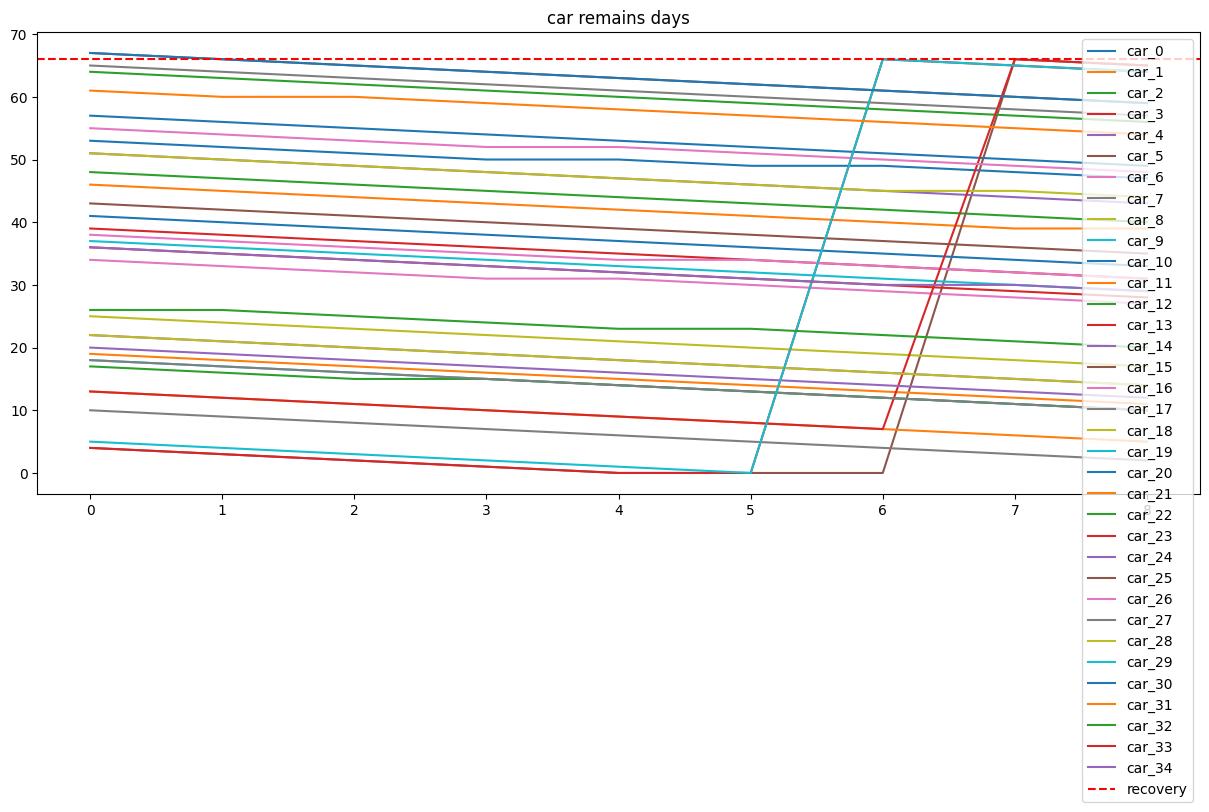

In [181]:
array = np.vstack(car_remaining_days_per_day)
plt.figure(figsize=(15, 6))
for i in range(num_cars):
    plt.plot(array[:, i], label=f'car_{i}')
plt.axhline(y=z_recovery_days, color='r', linestyle='--', label='recovery')
plt.title('car remains days')
plt.legend()
plt.show()

## 每台车每天未执行任务前剩余 z 里程

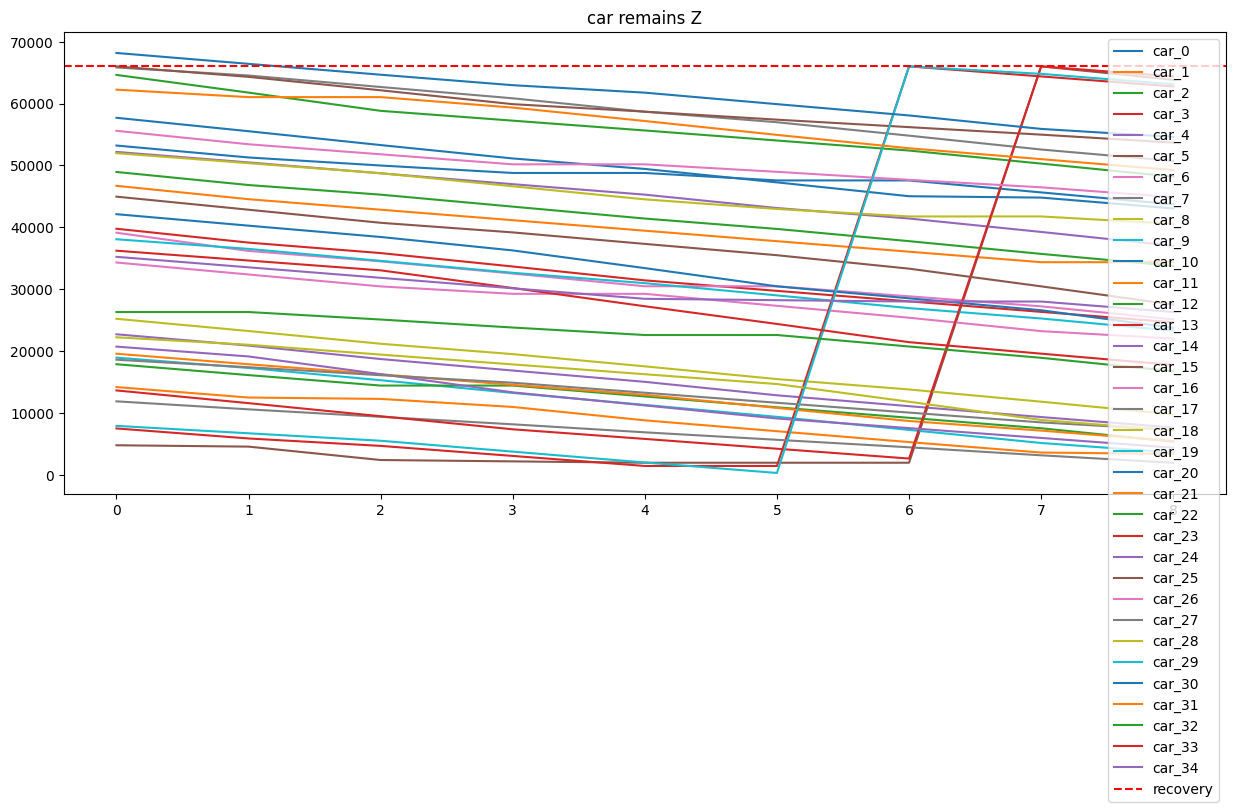

In [182]:
array = np.vstack(car_remaining_z_per_day)
plt.figure(figsize=(15, 6))
for i in range(num_cars):
    plt.plot(array[:, i], label=f'car_{i}')

plt.axhline(y=z_recovery_capacity, color='r', linestyle='--', label='recovery')
plt.title('car remains Z')
plt.legend()
plt.show()

## 每台车每天未执行任务前剩余 l 里程

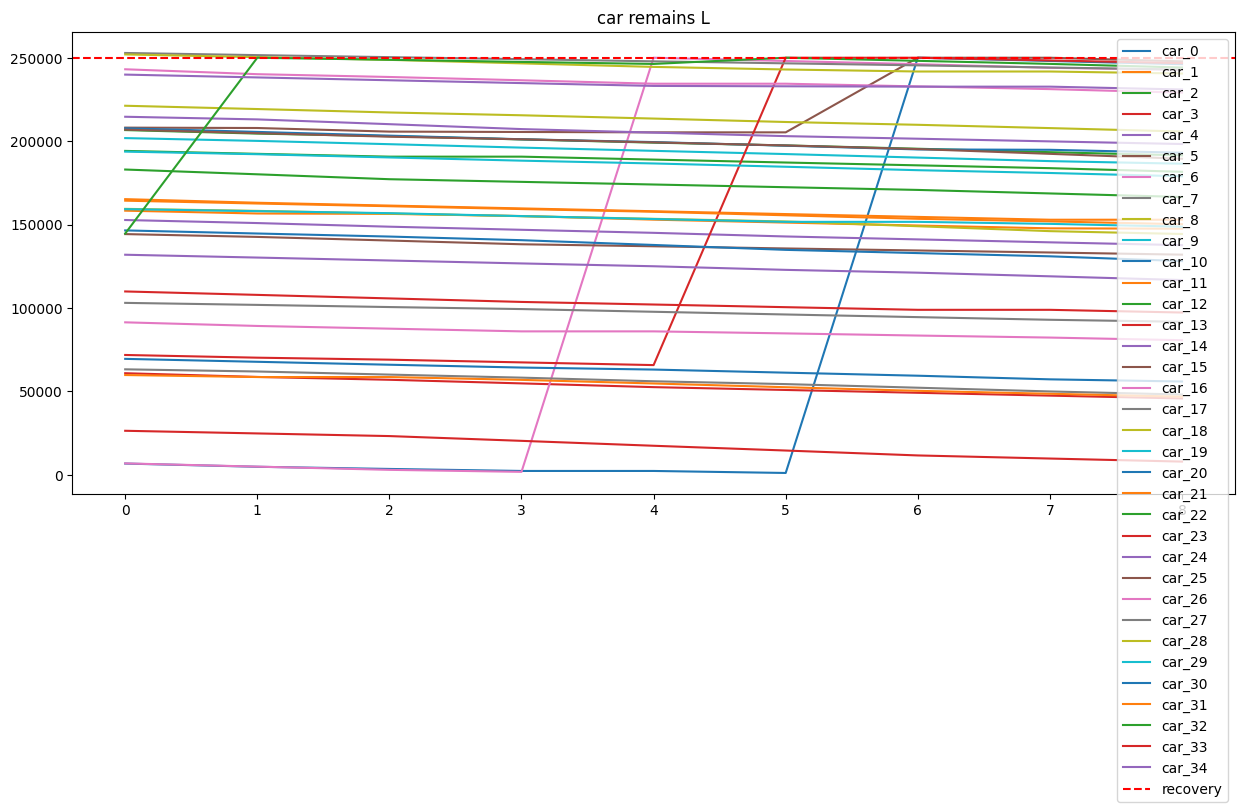

In [183]:
array = np.vstack(car_remaining_l_per_day)
plt.figure(figsize=(15, 6))
for i in range(num_cars):
    plt.plot(array[:, i], label=f'car_{i}')
plt.axhline(y=l_recovery_capacity, color='r', linestyle='--', label='recovery')
plt.title('car remains L')
plt.legend()
plt.show()